<a href="https://colab.research.google.com/github/shadab4150/Sound-Spectrogram-classifier/blob/master/environmental_sound_spectrogram_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip '/content/drive/My Drive/Dataset/sound_spectrogram_lebrosa.zip' -d '/content/sound/'

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate,fbeta
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
df = pd.read_csv('/content/drive/My Drive/Dataset/env_sound.csv')
df.head()

,filename,fold,target,category,esc10,src_file,take,fname
0,1-100032-A-0.wav,1,0,dog,True,100032,A,1-100032-A-0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,1-100038-A-14
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1-100210-A-36
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1-100210-B-36
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1-101296-A-19


* Sound files are divided into 5 folds, each fold containing 400 wav files, 8 of each 50 types

In [170]:
df.fold.unique()

array([1, 2, 3, 4, 5])

In [169]:
df[df['fold']==1].category.value_counts()

fireworks           8
siren               8
frog                8
toilet_flush        8
crickets            8
chirping_birds      8
dog                 8
crackling_fire      8
breathing           8
glass_breaking      8
door_wood_creaks    8
coughing            8
sea_waves           8
water_drops         8
can_opening         8
clock_alarm         8
pouring_water       8
door_wood_knock     8
chainsaw            8
hand_saw            8
train               8
washing_machine     8
snoring             8
engine              8
hen                 8
footsteps           8
clock_tick          8
wind                8
church_bells        8
rooster             8
helicopter          8
insects             8
car_horn            8
rain                8
mouse_click         8
sheep               8
airplane            8
keyboard_typing     8
laughing            8
crying_baby         8
drinking_sipping    8
thunderstorm        8
clapping            8
vacuum_cleaner      8
crow                8
cow       

### There are 50 types sounds in each fold, each type contains 8 files 
* I will use fold 1,2,3,4 for training, **total train spectrogram:** **1600** 
* fold 5 for validation, **total test spectrogram:**  **400**

In [0]:
train_idx,valid_idx=list(range(0,1600)),list(range(1600,2000))

In [0]:
train_idx

In [0]:
path=Path('/content/')

## Creating datablock of spectrograms for CNN

In [0]:
data = (ImageList.from_df(df,path=path, folder='sound', suffix='.png',cols='fname')
        .split_by_idxs(train_idx,valid_idx)
        .label_from_df(cols='category')
        .transform(size=228)
        .databunch(bs=128)).normalize(imagenet_stats) 

In [167]:
data.c, len(data.train_ds), len(data.valid_ds),

(50, 1600, 400)

#### There are 50 classes

### Below is a peak at the databunch created

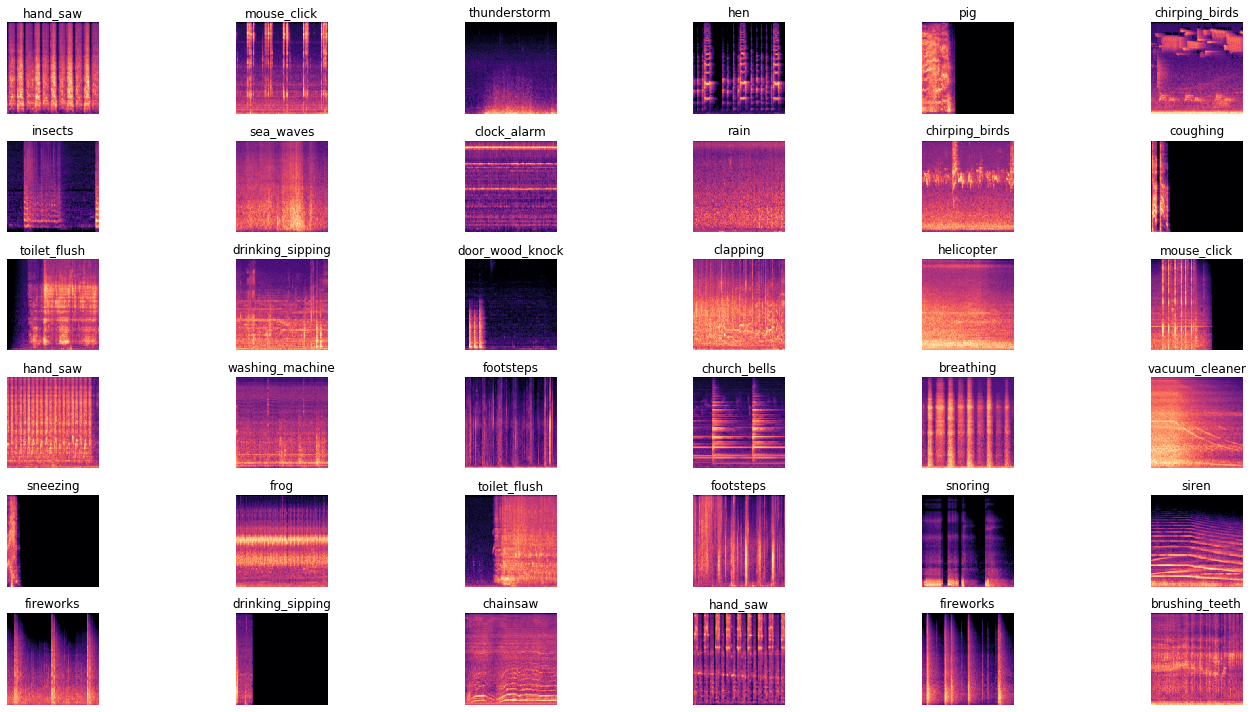

In [168]:
data.show_batch(rows=6,figsize=(20,10))

# I am using transfer learning.
## A pretrained resnet50 model will be used.

In [0]:
learn = cnn_learner(data,models.resnet50,metrics=[error_rate])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


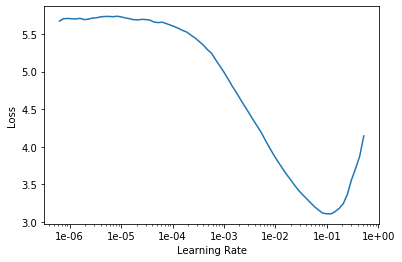

In [67]:
learn.lr_find()
learn.recorder.plot()

* Train for 8 epochs with a lr = 0.02

In [0]:
lr =0.02

In [74]:
learn.fit_one_cycle(8,slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,3.357963,2.926155,0.647500,00:12
1,2.045309,2.005764,0.442500,00:11
2,1.421279,1.761963,0.380000,00:11
3,1.064043,1.867605,0.362500,00:11
4,0.826908,1.915034,0.385000,00:11
5,0.636657,1.759683,0.355000,00:11
6,0.503902,1.666666,0.337500,00:11
7,0.396971,1.638371,0.332500,00:11


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


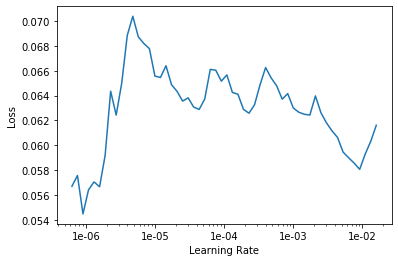

In [75]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.save('model1')
learn.load('model1')
learn.unfreeze()

In [77]:
learn.fit_one_cycle(12,slice(1e-5,lr/5),moms=0.6,wd=0.2)

epoch,train_loss,valid_loss,error_rate,time
0,0.058055,1.591743,0.327500,00:13
1,0.071508,1.860008,0.347500,00:12
2,0.260962,3.141192,0.487500,00:12
3,0.393165,2.954679,0.397500,00:12
4,0.380579,2.048923,0.350000,00:12
5,0.309728,1.491452,0.287500,00:12
6,0.243414,1.383525,0.262500,00:12
7,0.187663,1.366147,0.262500,00:12
8,0.144643,1.368474,0.260000,00:12
9,0.112655,1.355525,0.262500,00:12


### Saving the model and interpret results and for further fine tuning.

In [0]:
learn.save('model2')
learn.load('model2')
learn.unfreeze()

In [79]:
interp = ClassificationInterpretation.from_learner(learn)

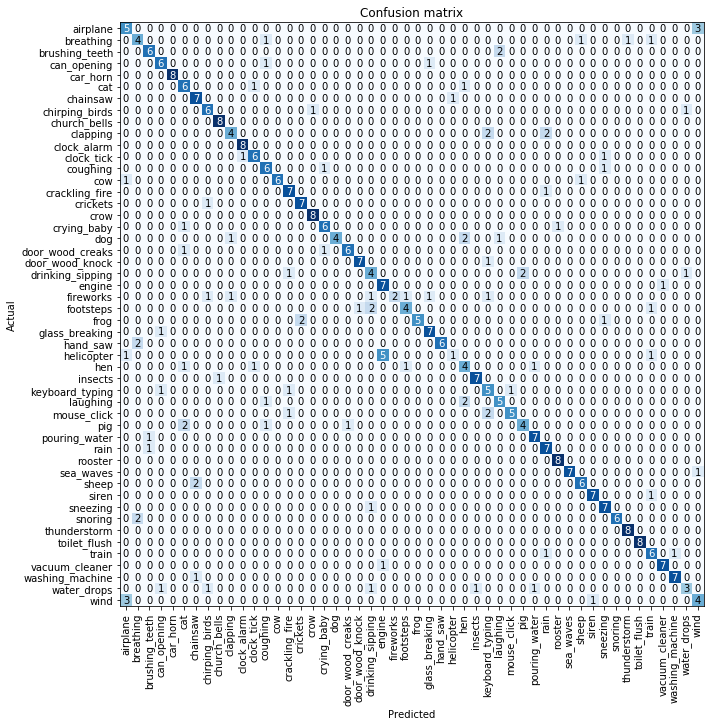

In [80]:
interp.plot_confusion_matrix(figsize=(20,10))

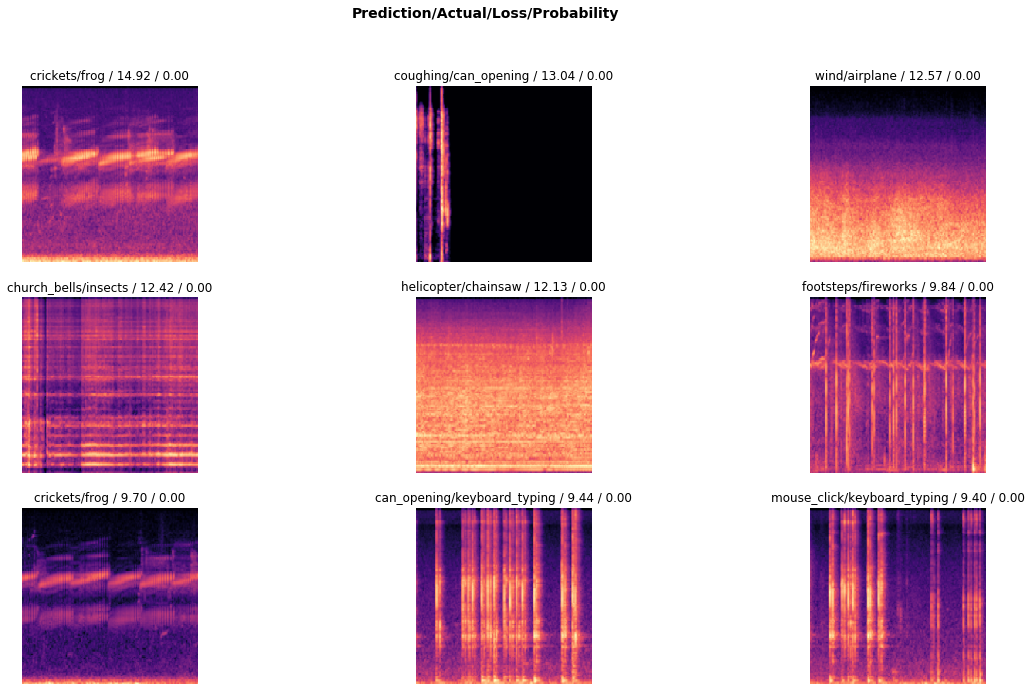

In [82]:
interp.plot_top_losses(9, figsize=(20,11))

* As we can see from above confusion matrix it gets most confused between:

  * between **helicopter** and **engine** is **5** times
  * between **airplane** and **wind** is **3** times
  * between **wind** and  **airplane** is **3** times

In [86]:
interp.most_confused()

[('helicopter', 'engine', 5),
 ('airplane', 'wind', 3),
 ('wind', 'airplane', 3),
 ('brushing_teeth', 'laughing', 2),
 ('clapping', 'keyboard_typing', 2),
 ('clapping', 'rain', 2),
 ('dog', 'hen', 2),
 ('drinking_sipping', 'pig', 2),
 ('footsteps', 'drinking_sipping', 2),
 ('frog', 'crickets', 2),
 ('hand_saw', 'breathing', 2),
 ('laughing', 'hen', 2),
 ('mouse_click', 'keyboard_typing', 2),
 ('pig', 'cat', 2),
 ('sheep', 'chainsaw', 2),
 ('snoring', 'breathing', 2),
 ('breathing', 'coughing', 1),
 ('breathing', 'sheep', 1),
 ('breathing', 'thunderstorm', 1),
 ('breathing', 'train', 1),
 ('can_opening', 'coughing', 1),
 ('can_opening', 'glass_breaking', 1),
 ('cat', 'clock_tick', 1),
 ('cat', 'hen', 1),
 ('chainsaw', 'helicopter', 1),
 ('chirping_birds', 'crow', 1),
 ('chirping_birds', 'water_drops', 1),
 ('clock_tick', 'clock_alarm', 1),
 ('clock_tick', 'sneezing', 1),
 ('coughing', 'crying_baby', 1),
 ('coughing', 'sneezing', 1),
 ('cow', 'airplane', 1),
 ('cow', 'sheep', 1),
 ('crac

In [87]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


### Fine tuning the model
* Now I will train the last **two** layers with **dropout = 0.5**

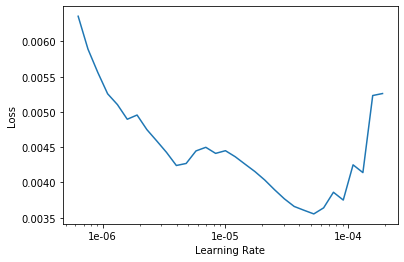

In [92]:
learn.recorder.plot()

In [95]:
learn.load('model2')
learn.unfreeze()
learn.fit_one_cycle(8,slice(1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.005912,1.435818,0.275000,00:12
1,0.016856,1.548132,0.332500,00:12
2,0.039732,1.500822,0.305000,00:12
3,0.047312,1.436614,0.260000,00:12
4,0.036961,1.350214,0.262500,00:12
5,0.028633,1.297539,0.257500,00:12
6,0.022042,1.274629,0.250000,00:12
7,0.018516,1.274561,0.252500,00:12


## Current accuracy is **74.75 %**

In [0]:
learn.save('model3')

In [0]:
learn = cnn_learner(data,models.resnet50,metrics=[error_rate],ps=0.5)

In [108]:
learn.load('model3')

Learner(data=ImageDataBunch;

Train: LabelList (1600 items)
x: ImageList
Image (3, 228, 228),Image (3, 228, 228),Image (3, 228, 228),Image (3, 228, 228),Image (3, 228, 228)
y: CategoryList
dog,chirping_birds,vacuum_cleaner,vacuum_cleaner,thunderstorm
Path: /content;

Valid: LabelList (400 items)
x: ImageList
Image (3, 228, 228),Image (3, 228, 228),Image (3, 228, 228),Image (3, 228, 228),Image (3, 228, 228)
y: CategoryList
pig,pig,pig,pig,pig
Path: /content;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


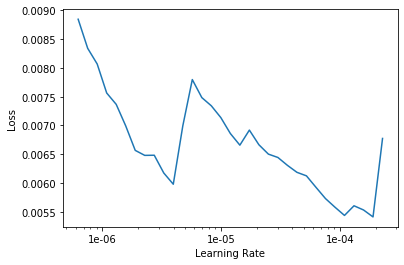

In [111]:
learn.load('model4')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [109]:
learn.freeze_to(-2)
learn.fit_one_cycle(8,slice(1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.003430,1.255109,0.252500,00:12
1,0.003632,1.261862,0.270000,00:12
2,0.009780,1.638411,0.317500,00:12
3,0.022437,1.579602,0.307500,00:12
4,0.031053,1.388391,0.275000,00:12
5,0.028362,1.298395,0.260000,00:12
6,0.023306,1.248281,0.247500,00:12
7,0.020378,1.228462,0.247500,00:12


In [0]:
learn.save('model4')

In [112]:
learn.freeze_to(-2)
learn.fit_one_cycle(8,slice(1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.009120,1.219319,0.242500,00:11
1,0.006997,1.184711,0.232500,00:11
2,0.004822,1.176667,0.235000,00:11
3,0.004167,1.171325,0.232500,00:11
4,0.003328,1.166842,0.237500,00:11
5,0.003497,1.168375,0.240000,00:11
6,0.003090,1.160852,0.240000,00:11
7,0.002570,1.165870,0.242500,00:11


In [0]:
learn.save('model5')
learn.load('model5');

In [115]:
learn.freeze_to(-2)
learn.fit_one_cycle(4,slice(1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.001649,1.167910,0.237500,00:11
1,0.002511,1.138656,0.232500,00:11
2,0.002321,1.140570,0.232500,00:11
3,0.001917,1.128556,0.232500,00:11


In [0]:
learn.save('model6')
learn.load('model6');

In [122]:
learn.unfreeze()
learn.freeze_to(-2)
learn.fit_one_cycle(6,1e-5,moms=(0.6,0.7))

epoch,train_loss,valid_loss,error_rate,time
0,0.001815,1.120498,0.232500,00:11
1,0.001272,1.128594,0.235000,00:11
2,0.001065,1.125435,0.222500,00:11
3,0.000883,1.119482,0.225000,00:11
4,0.000787,1.108891,0.222500,00:11
5,0.000772,1.108978,0.225000,00:11


In [0]:
learn.save('model7')
learn.load('model7');

In [127]:
learn.unfreeze()
learn.freeze_to(-1)
learn.fit_one_cycle(8,1e-5,moms=(0.8,0.9))

epoch,train_loss,valid_loss,error_rate,time
0,0.000365,1.119476,0.227500,00:11
1,0.000324,1.122993,0.225000,00:10
2,0.000333,1.128753,0.227500,00:11
3,0.000474,1.133332,0.225000,00:10
4,0.000515,1.128222,0.225000,00:10
5,0.000480,1.121122,0.220000,00:10
6,0.000568,1.119718,0.227500,00:10
7,0.000522,1.124548,0.220000,00:11


# Final accuracy is **78%**

In [0]:
learn.save('final_sound')
learn.load('final_sound');

### Saving the model and analysing the result

In [130]:
interp = ClassificationInterpretation.from_learner(learn)

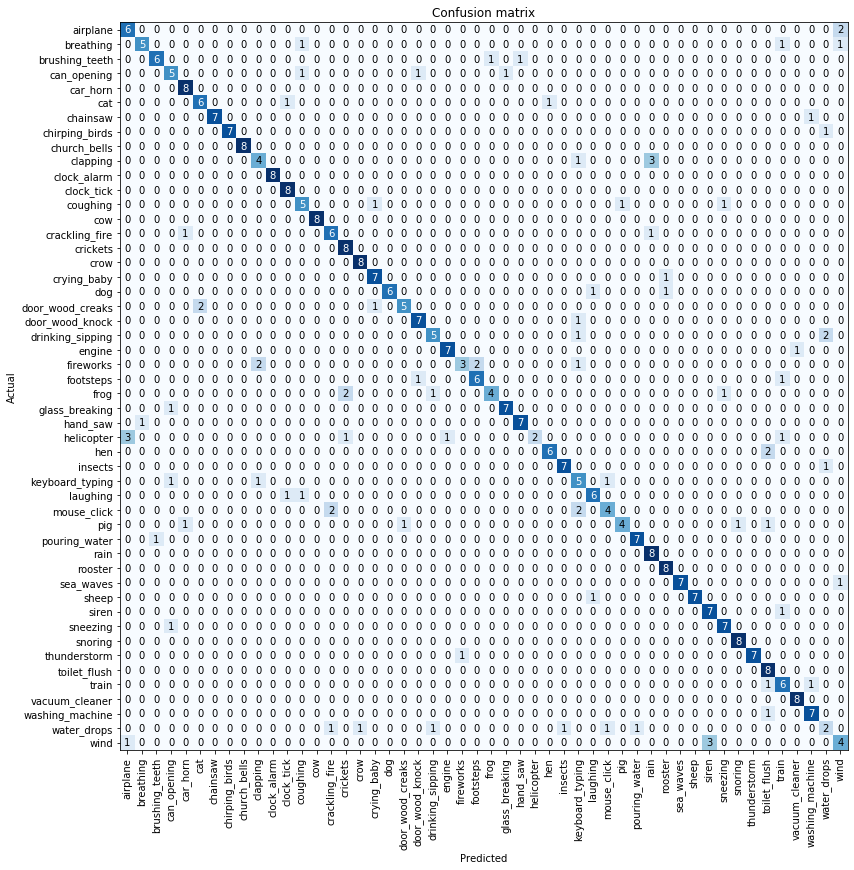

In [157]:
interp.plot_confusion_matrix(figsize=(20,12))

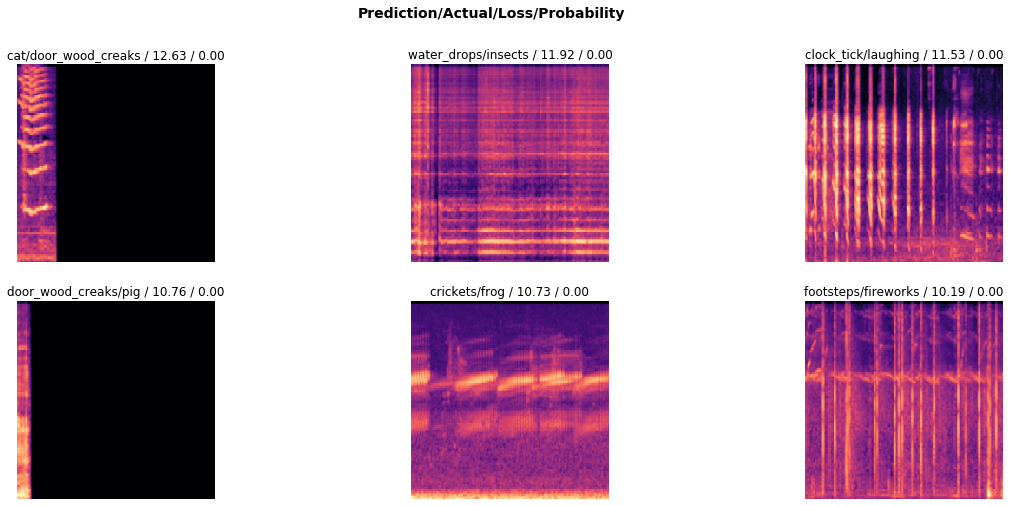

In [159]:
interp.plot_top_losses(6, figsize=(20,8))

In [171]:
interp.most_confused(min_val=3)

[('clapping', 'rain', 3), ('helicopter', 'airplane', 3), ('wind', 'siren', 3)]

* As we can see from above confusion matrix it gets most confused between:

  * between **clapping** and **rain** is **3** times
  * between **helicopter** and **airplane** is **3** times
  * between **wind** and  **siren** is **3** times

## Final accuracy is **78%**

In [0]:
learn.export('/content/drive/My Drive/Dataset/sound_spec.pkl')

### Exporting the model

#### copying the model to drive

In [0]:
!cp '/content/models/final_sound.pth' '/content/drive/My Drive/Dataset/'